In [12]:
# !pip install lightgbm
# !pip install xgboost

In [3]:
# --- NOTEBOOK 05: THE TREEHOUSE ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import logging
from time import time

# The Models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb 

# Metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class Config:
    INPUT_PATH = 'engineered_data.parquet'
    SEED = 42
    N_FOLDS = 5 # Standard for Validation
    
    # Random Forest Params (Benchmark)
    RF_PARAMS = {
        'n_estimators': 200,
        'max_depth': 10,      # Constrain depth to prevent overfitting
        'n_jobs': -1,
        'random_state': 42,
        'verbose': 0
    }
    
    # LightGBM Params (The Real Deal)
    # These are "Grandmaster" starting params for Credit Risk
    LGBM_PARAMS = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'learning_rate': 0.05,    # Slow and steady wins the race
        'num_leaves': 31,         # Standard complexity
        'max_depth': -1,          # No limit (relies on num_leaves)
        'min_child_samples': 20,  # Prevent overfitting on outliers
        'reg_alpha': 10,          # L1 Regularization (Lasso style)
        'reg_lambda': 0.1,        # L2 Regularization (Ridge style)
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }

logger.info("Notebook 05 Initialized.")

2026-01-20 08:04:49,316 - INFO - Notebook 05 Initialized.


In [4]:
def run_random_forest_benchmark():
    logger.info("--- LOADING DATA ---")
    df = pd.read_parquet(Config.INPUT_PATH)
    
    # Split
    X = df.drop(columns=['TARGET', 'SK_ID_CURR']) # Drop ID
    y = df['TARGET']
    
    # Handle Categories for Sklearn RF
    # RF cannot handle 'category' type natively like LightGBM. 
    # We must convert them to int codes explicitly.
    for col in X.select_dtypes(include=['category']).columns:
        X[col] = X[col].cat.codes
        
    # Simple Train/Test Split (not K-Fold for benchmark to save time)
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=Config.SEED)
    
    # Fill NaN for Random Forest (It crashes on NaNs)
    # Note: LightGBM handles NaNs natively, but RF does not.
    X_train = X_train.fillna(-999)
    X_val = X_val.fillna(-999)
    
    logger.info(f"--- TRAINING RANDOM FOREST ({Config.RF_PARAMS['n_estimators']} Trees) ---")
    start = time()
    rf = RandomForestClassifier(**Config.RF_PARAMS)
    rf.fit(X_train, y_train)
    end = time()
    
    # Evaluate
    probs = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, probs)
    
    logger.info(f"Random Forest AUC: {auc:.4f}")
    logger.info(f"Training Time: {end - start:.1f} seconds")
    
    return rf, X.columns

# Run the Benchmark
# rf_model, feature_names = run_random_forest_benchmark()

In [6]:
# Run the Benchmark
rf_model, feature_names = run_random_forest_benchmark()
print(rf_model, feature_names)

2026-01-20 08:06:09,537 - INFO - --- LOADING DATA ---
2026-01-20 08:06:10,041 - INFO - --- TRAINING RANDOM FOREST (200 Trees) ---
2026-01-20 08:06:38,094 - INFO - Random Forest AUC: 0.7460
2026-01-20 08:06:38,095 - INFO - Training Time: 27.6 seconds


RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1,
                       random_state=42) Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_EMPLOYED_ANOM',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'NEW_CREDIT_TO_INCOME_RATIO',
       'NEW_ANNUITY_TO_INCOME_RATIO', 'NEW_CREDIT_TO_GOODS_RATIO',
       'NEW_EMPLOYED_TO_BIRTH_RATIO', 'NEW_EXT_SOURCES_MEAN',
       'NEW_EXT_SOURCES_STD', 'NEW_EXT_SOURCES_MIN'],
      dtype='object', length=129)


In [13]:
# Function to run XGBoost Benchmark
import xgboost as xgb 

def run_xgboost_benchmark():
    logger.info("--- STARTING XGBOOST BENCHMARK ---")
    
    # 1. Load Data
    df = pd.read_parquet(Config.INPUT_PATH)
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = df['TARGET']
    
    # 2. XGBoost Params (Comparable to LightGBM)
    xgb_params = {
        'n_estimators': 2000,
        'learning_rate': 0.05,
        'max_depth': 6,             # XGBoost prefers depth-wise growth
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'enable_categorical': True, # Modern XGBoost handles categories natively!
        'n_jobs': -1,
        'random_state': Config.SEED,
        'tree_method': 'hist',      # Use Histogram method (much faster)
        'device': 'cpu'             # Change to 'cuda' if you have a GPU
    }
    
    # 3. Split (Simple Split for Benchmark)
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=Config.SEED)
    
    logger.info("Training XGBoost...")
    start = time()
    
    model = xgb.XGBClassifier(**xgb_params, early_stopping_rounds=100, eval_metric='auc')
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=500
    )
    
    end = time()
    
    # 4. Results
    val_preds = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, val_preds)
    
    logger.info(f"XGBoost Benchmark AUC: {score:.4f}")
    logger.info(f"Training Time: {end - start:.1f} seconds")
    
    return model

# Execute
xgb_model = run_xgboost_benchmark()

2026-01-20 08:27:11,241 - INFO - --- STARTING XGBOOST BENCHMARK ---
2026-01-20 08:27:11,635 - INFO - Training XGBoost...


[0]	validation_0-auc:0.72484
[500]	validation_0-auc:0.76684
[582]	validation_0-auc:0.76628


2026-01-20 08:27:48,691 - INFO - XGBoost Benchmark AUC: 0.7670
2026-01-20 08:27:48,692 - INFO - Training Time: 36.8 seconds


In [7]:
def run_lightgbm_kfold():
    logger.info("--- STARTING LIGHTGBM 5-FOLD ---")
    
    df = pd.read_parquet(Config.INPUT_PATH)
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = df['TARGET']
    
    # Stratified K-Fold
    folds = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.SEED)
    
    oof_preds = np.zeros(len(X)) # Out-of-Fold predictions
    feature_importance = pd.DataFrame()
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        logger.info(f"Training Fold {fold + 1}...")
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        # LightGBM Dataset (Optimized binary format)
        # We tell it which columns are categorical!
        # cat_cols = X.select_dtypes(include=['category']).columns.tolist()
        
        model = lgb.LGBMClassifier(**Config.LGBM_PARAMS)
        
        # Callbacks (Early Stopping)
        callbacks = [
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=500)
        ]
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_names=['train', 'valid'],
            eval_metric='auc',
            callbacks=callbacks
        )
        
        # Predict
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        
        # Score
        score = roc_auc_score(y_val, val_preds)
        scores.append(score)
        logger.info(f"Fold {fold + 1} AUC: {score:.4f}")
        
        # Extract Importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
    logger.info(f"--- K-FOLD FINISHED ---")
    logger.info(f"Mean AUC: {np.mean(scores):.4f} +/- {np.std(scores):.4f}")
    
    return feature_importance

# Execute
fi_df = run_lightgbm_kfold()

2026-01-20 08:07:00,683 - INFO - --- STARTING LIGHTGBM 5-FOLD ---
2026-01-20 08:07:00,853 - INFO - Training Fold 1...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.828854	valid's auc: 0.762889
Early stopping, best iteration is:
[525]	train's auc: 0.831175	valid's auc: 0.76306


2026-01-20 08:07:30,415 - INFO - Fold 1 AUC: 0.7631
2026-01-20 08:07:30,423 - INFO - Training Fold 2...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.827695	valid's auc: 0.775058
Early stopping, best iteration is:
[588]	train's auc: 0.835794	valid's auc: 0.775263


2026-01-20 08:08:06,789 - INFO - Fold 2 AUC: 0.7753
2026-01-20 08:08:06,799 - INFO - Training Fold 3...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.828801	valid's auc: 0.764568
Early stopping, best iteration is:
[552]	train's auc: 0.833296	valid's auc: 0.764692


2026-01-20 08:08:43,056 - INFO - Fold 3 AUC: 0.7647
2026-01-20 08:08:43,065 - INFO - Training Fold 4...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.827938	valid's auc: 0.774582
Early stopping, best iteration is:
[526]	train's auc: 0.830158	valid's auc: 0.774819


2026-01-20 08:09:19,253 - INFO - Fold 4 AUC: 0.7748
2026-01-20 08:09:19,262 - INFO - Training Fold 5...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.82828	valid's auc: 0.76747
Early stopping, best iteration is:
[521]	train's auc: 0.830139	valid's auc: 0.767525


2026-01-20 08:09:53,202 - INFO - Fold 5 AUC: 0.7675
2026-01-20 08:09:53,206 - INFO - --- K-FOLD FINISHED ---
2026-01-20 08:09:53,207 - INFO - Mean AUC: 0.7691 +/- 0.0051


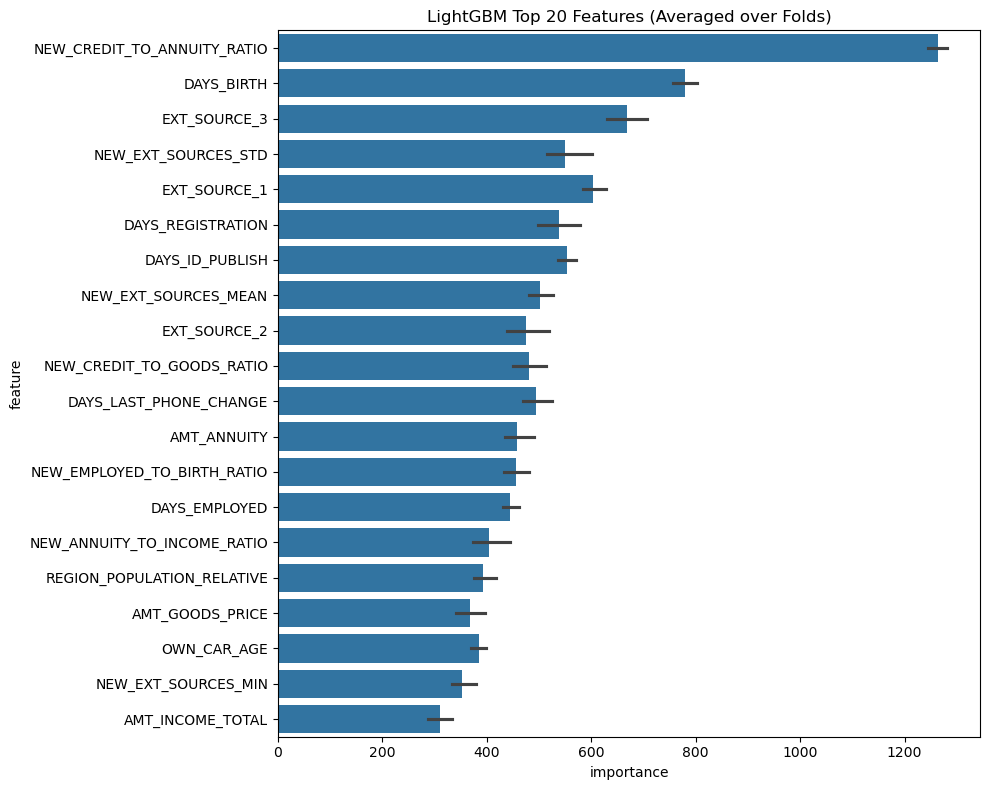

In [8]:
def plot_feature_importance(df):
    # Aggregating over 5 folds
    cols = (df[["feature", "importance"]]
            .groupby("feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:20].index)
    
    best_features = df.loc[df.feature.isin(cols)]
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Top 20 Features (Averaged over Folds)')
    plt.tight_layout()
    plt.show()

# Visualize
plot_feature_importance(fi_df)

Summary:

1. Linear Model (NB 02): AUC 0.740

2. Random Forest (NB 05 Benchmark): AUC 0.746 (+0.6%)

3. XGBoost (NB 05 Contender): AUC 0.767 (+2.7%)

4. LightGBM (NB 05 Champion): AUC 0.769 (+2.9%)

2026-01-20 12:01:33,795 - INFO - --- STARTING LIGHTGBM 5-FOLD ---
2026-01-20 12:01:35,335 - INFO - Training Fold 1...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.842683	valid's auc: 0.768279
Early stopping, best iteration is:
[691]	train's auc: 0.861175	valid's auc: 0.768822


2026-01-20 12:04:27,082 - INFO - Fold 1 AUC: 0.7688
2026-01-20 12:04:27,103 - INFO - Training Fold 2...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.842191	valid's auc: 0.782099
Early stopping, best iteration is:
[484]	train's auc: 0.840488	valid's auc: 0.782207


2026-01-20 12:06:32,507 - INFO - Fold 2 AUC: 0.7822
2026-01-20 12:06:32,526 - INFO - Training Fold 3...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.842502	valid's auc: 0.771675
Early stopping, best iteration is:
[655]	train's auc: 0.8578	valid's auc: 0.77197


2026-01-20 12:08:59,659 - INFO - Fold 3 AUC: 0.7720
2026-01-20 12:08:59,679 - INFO - Training Fold 4...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.842229	valid's auc: 0.779311
Early stopping, best iteration is:
[506]	train's auc: 0.842932	valid's auc: 0.779348


2026-01-20 12:11:13,707 - INFO - Fold 4 AUC: 0.7793
2026-01-20 12:11:13,726 - INFO - Training Fold 5...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.842379	valid's auc: 0.774414
Early stopping, best iteration is:
[642]	train's auc: 0.856057	valid's auc: 0.774948


2026-01-20 12:13:48,228 - INFO - Fold 5 AUC: 0.7749
2026-01-20 12:13:48,239 - INFO - --- K-FOLD FINISHED ---
2026-01-20 12:13:48,242 - INFO - Mean AUC: 0.7755 +/- 0.0048


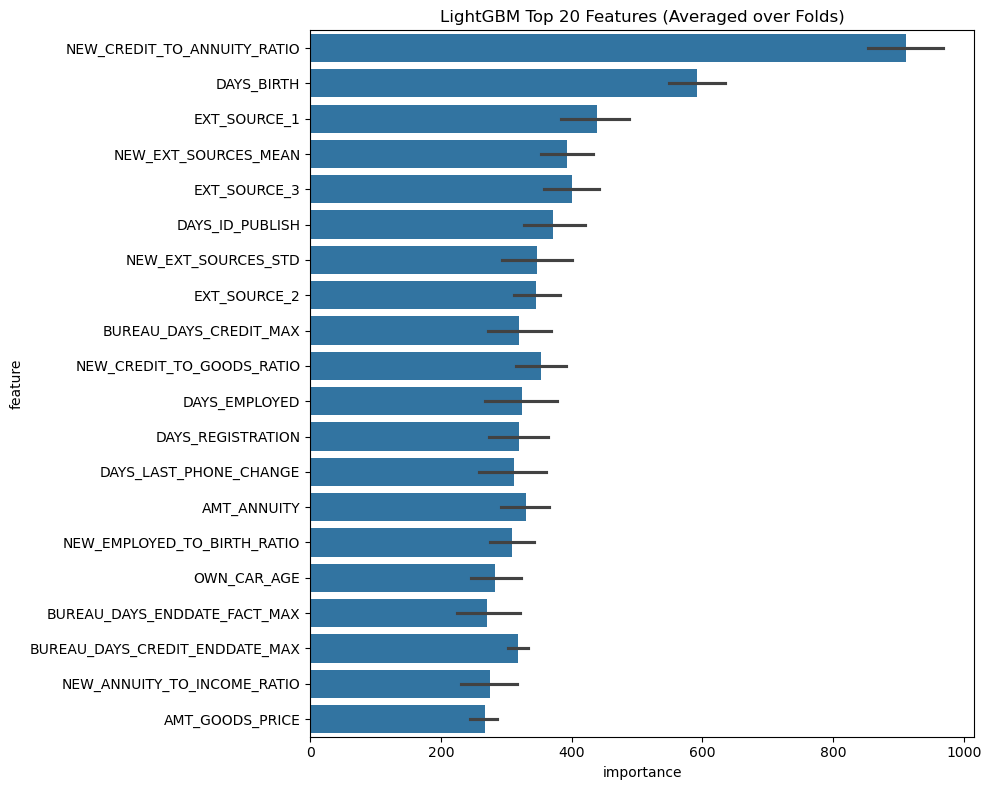

In [14]:
# --- VALIDATION: LIGHTGBM ON BUREAU DATA ---

# 1. Update Config to point to the NEW merged file
class Config:
    INPUT_PATH = 'train_bureau_merged.parquet'  
    SEED = 42
    N_FOLDS = 5
    LGBM_PARAMS = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'reg_alpha': 10,
        'reg_lambda': 0.1,
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }

# 2. Run the existing LightGBM function
# (Make sure 'run_lightgbm_kfold' is defined in your current kernel)
fi_df_bureau = run_lightgbm_kfold()

# 3. Plot New Importance
plot_feature_importance(fi_df_bureau)

2026-01-20 12:59:01,972 - INFO - --- STARTING LIGHTGBM 5-FOLD ---
2026-01-20 12:59:02,975 - INFO - Training Fold 1...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.832629	valid's auc: 0.780477
[1000]	train's auc: 0.867074	valid's auc: 0.782696
Early stopping, best iteration is:
[1188]	train's auc: 0.877509	valid's auc: 0.783028


2026-01-20 13:00:58,221 - INFO - Fold 1 AUC: 0.7830
2026-01-20 13:00:58,230 - INFO - Training Fold 2...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.831377	valid's auc: 0.791726
[1000]	train's auc: 0.865952	valid's auc: 0.792972
Early stopping, best iteration is:
[1122]	train's auc: 0.873008	valid's auc: 0.793173


2026-01-20 13:02:53,185 - INFO - Fold 2 AUC: 0.7932
2026-01-20 13:02:53,194 - INFO - Training Fold 3...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.833144	valid's auc: 0.780789
[1000]	train's auc: 0.866486	valid's auc: 0.782781
Early stopping, best iteration is:
[1070]	train's auc: 0.870589	valid's auc: 0.782852


2026-01-20 13:04:41,372 - INFO - Fold 3 AUC: 0.7829
2026-01-20 13:04:41,382 - INFO - Training Fold 4...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.832187	valid's auc: 0.787162
[1000]	train's auc: 0.865815	valid's auc: 0.788665
Early stopping, best iteration is:
[1062]	train's auc: 0.869461	valid's auc: 0.788924


2026-01-20 13:06:36,371 - INFO - Fold 4 AUC: 0.7889
2026-01-20 13:06:36,379 - INFO - Training Fold 5...


Training until validation scores don't improve for 100 rounds
[500]	train's auc: 0.832328	valid's auc: 0.781813
[1000]	train's auc: 0.865822	valid's auc: 0.783518
Early stopping, best iteration is:
[1338]	train's auc: 0.884018	valid's auc: 0.78402


2026-01-20 13:08:55,393 - INFO - Fold 5 AUC: 0.7840
2026-01-20 13:08:55,398 - INFO - --- K-FOLD FINISHED ---
2026-01-20 13:08:55,399 - INFO - Mean AUC: 0.7864 +/- 0.0040


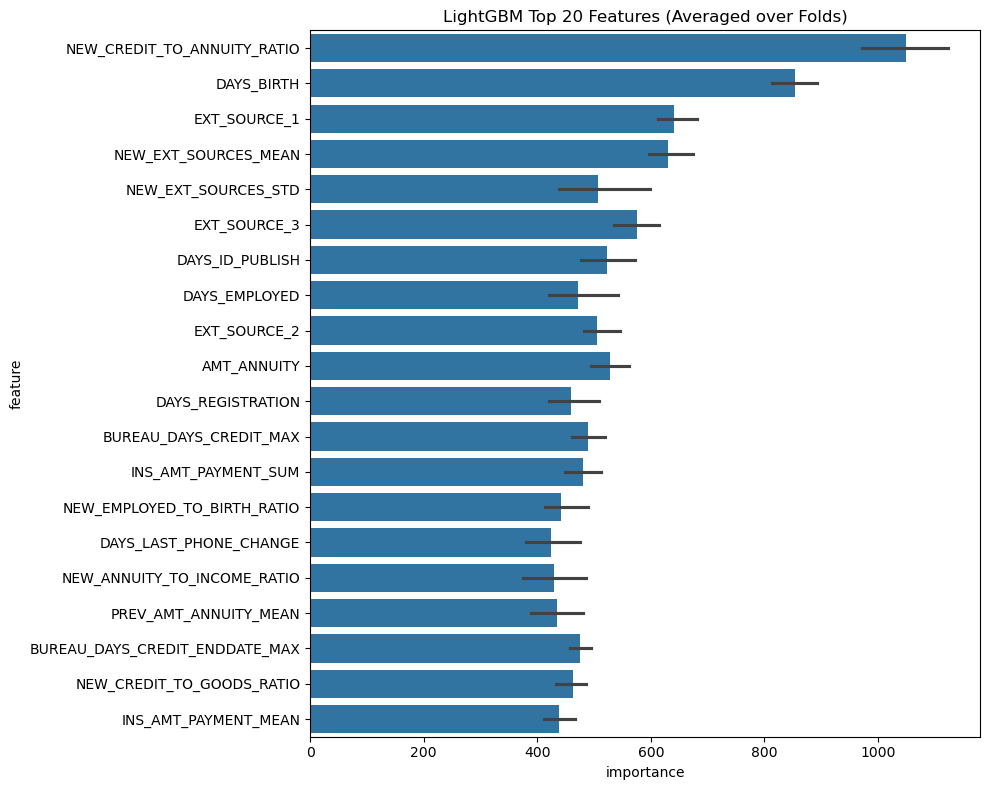

In [15]:
# --- VALIDATION: LIGHTGBM ON FULL DATASET ---

# 1. Update Config to point to the FINAL merged file
class Config:
    INPUT_PATH = 'train_full_merged.parquet'  # <--- THE FINAL BOSS
    SEED = 42
    N_FOLDS = 5
    # Same params as before
    LGBM_PARAMS = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 3000,     # Increased to 3000 to digest more data
        'learning_rate': 0.03,    # Slower rate for better convergence
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'reg_alpha': 10,
        'reg_lambda': 0.1,
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }

# 2. Run the existing LightGBM function
# (Ensure 'run_lightgbm_kfold' and 'plot_feature_importance' are defined)
fi_df_full = run_lightgbm_kfold()

# 3. Plot New Importance
plot_feature_importance(fi_df_full)